# INVEMAR Modelo de Velocidad del Viento

Considere los datos de velocidad del viento del INVEMAR adjuntos en esta tarea. Para cada isla:

Seleccione un período de observación de dos semanas.
A partir de estos, obtenga las velocidades del viento.
Construya un modelo no lineal para cada isla que imite el comportamiento de la velocidad del viento durante los períodos de observación (por ejemplo, elija la forma y los parámetros de su modelo).
Ajusta los parámetros de los modelos propuestos utilizando el método de Newton (puedes seleccionar los puntos iniciales que más te convengan).
Trace la norma del gradiente entre iteraciones, seleccione el número de iteraciones y, finalmente,
Traza los residuos de tu modelo. ¿Qué conclusiones sacas de esto?

**Integrantes:** Kenny dong Jie Zhu Ye (200164380), Set David Salas Redondo (200166321)

In [8]:
import pandas as pd
import sympy as sp
from IPython.display import Math
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# cargar los datos

In [9]:
# Cargar los datos del archivo Excel proporcionado
datos = pd.read_excel("/content/Data_INVEMAR.xlsx")

# Mostrar las primeras filas de los datos para entender su estructura
datos.head()

,"Fecha,Hora,Variable,Valor,Unidad,Lugar"
0,"42736,0,Velocidad del viento,8.43,m/s,Punta Betin"
1,"42736,1,Velocidad del viento,8.78,m/s,Punta Betin"
2,"42736,2,Velocidad del viento,11,m/s,Punta Betin"
3,"42736,3,Velocidad del viento,12.3,m/s,Punta Betin"
4,"42736,4,Velocidad del viento,10.47,m/s,Punta B..."


In [10]:
# Dividir la única columna en múltiples columnas basado en el delimitador de coma
datos_divididos = datos["Fecha,Hora,Variable,Valor,Unidad,Lugar"].str.split(',', expand=True)

# Renombrar las columnas basado en los valores de la primera fila
datos_divididos.columns = ["Fecha", "Hora", "Variable", "Valor", "Unidad", "Lugar"]

# Mostrar los datos procesados
datos_divididos.head()

,Fecha,Hora,Variable,Valor,Unidad,Lugar
0,42736,0,Velocidad del viento,8.43,m/s,Punta Betin
1,42736,1,Velocidad del viento,8.78,m/s,Punta Betin
2,42736,2,Velocidad del viento,11,m/s,Punta Betin
3,42736,3,Velocidad del viento,12.3,m/s,Punta Betin
4,42736,4,Velocidad del viento,10.47,m/s,Punta Betin


In [11]:
# Identificar los lugares/islas únicos en el conjunto de datos
islas_unicas = datos_divididos["Lugar"].unique()
islas_unicas

array(['Punta Betin', 'Isla Tesoro', 'Johnny Cay'], dtype=object)

In [12]:
# Seleccionar un período de observación de dos semanas para Punta Betin
x = datos_divididos[datos_divididos["Lugar"] == "Punta Betin"].head(336)["Valor"].astype(float)

x = np.array(x)

## Modelo
El modelo a utilizar es:
$$\mathcal{M(\theta,\mathbf{x})}=x_0* \theta_0^2*cos(\theta_1*x_1)$$

In [13]:
# Derivación del modelo propuesto
m = sp.parse_expr('x0*t0**2*cos(t1*x1)')
display(Math(sp.latex(m)))

ts_simple = sp.Matrix(['t0', 't1'])
gt_simple = sp.Matrix([m.diff(t) for t in ts_simple])
display(Math(sp.latex(gt_simple)))

Ht_simple = sp.Matrix([[f.diff(t) for t in ts_simple] for f in gt_simple])
display(Math(sp.latex(Ht_simple)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [14]:
# Implementación del modelo propuesto, gradiente y hessiano

def model_(x, t):
    """Modelo propuesto para la velocidad del viento."""
    return x[0]*t[0]**2*np.cos(t[1]*x[1])

def model_g(x, t):
    """Gradiente del modelo propuesto respecto a los parámetros."""
    return np.array([
        2*t[0]*x[0]*np.cos(t[1]*x[1]),
        -t[0]**2*x[0]*x[1]*np.sin(t[1]*x[1])
    ])

def model_H(x, t):
    """Hessiano del modelo propuesto respecto a los parámetros."""
    return np.array([
        [2*x[0]*np.cos(t[1]*x[1]), -2*t[0]*x[0]*x[1]*np.sin(t[1]*x[1])],
        [-2*t[0]*x[0]*x[1]*np.sin(t[1]*x[1]), -t[0]**2*x[0]*x[1]**2*np.cos(t[1]*x[1])]
    ])

In [17]:
# Probar las funciones
xp = [1,4]
tp = [2, 2*np.pi/24]
print(model_(xp, tp))
print(model_g(xp, tp))
print(model_H(xp, tp))

2.0000000000000004
[  2.         -13.85640646]
[[  1.         -13.85640646]
 [-13.85640646 -32.        ]]


In [18]:
n = len(x)

x_values = [[xi,xj] for xj in x for xi in x]

t_opt = np.array([5,10])
Z = []
for xi in x_values:
    Z.append(model_(xi,t_opt))

Z = np.array(Z)
Z = np.reshape(Z,(n,n))

X1,X2 = np.meshgrid(x,x)

In [19]:
fig = go.Figure(data=[go.Surface(z=Z)])
fig.show()

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 [Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10'),
  Text(0, 12.0, '12'),
  Text(0, 14.0, '14'),
  Text(0, 16.0, '16')])

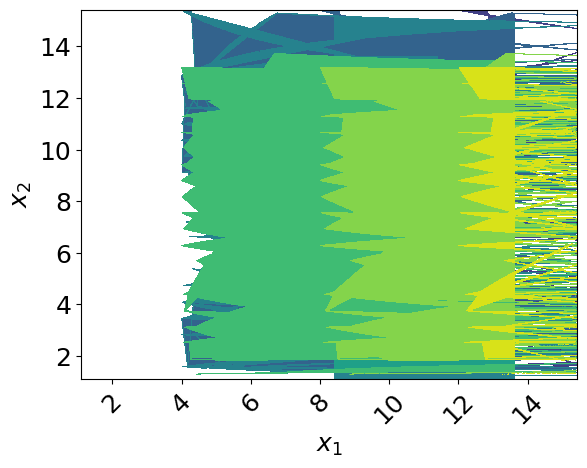

In [20]:
plt.contourf(X1,X2,Z)
plt.xlabel('$x_1$',fontdict={'size':18})
plt.ylabel('$x_2$',fontdict={'size':18})
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=18)

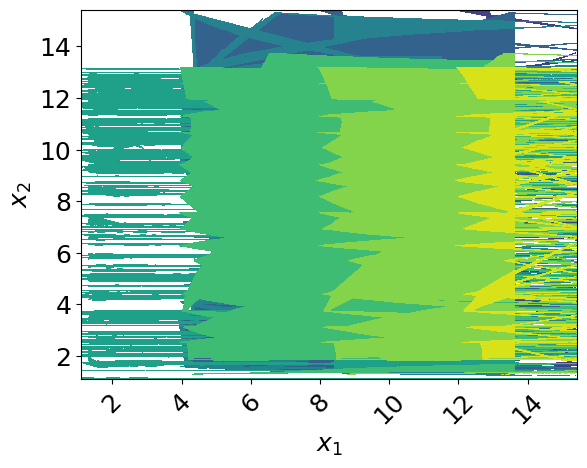

In [21]:
sig_obs = 1

Z_obs = Z + sig_obs*np.random.randn(n,n)
plt.contourf(X1,X2,Z_obs)
plt.xlabel('$x_1$',fontdict={'size':18})
plt.ylabel('$x_2$',fontdict={'size':18})
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=18);

## Error

In [22]:
def error_(x,t,y):
  return y - model_(x,t)

def error_g(x,t):
  return -model_g(x,t)

def error_H(x,t):
  return -model_H(x,t)

## Funciones de Costo

In [23]:
def J_(x_values,t,Y_obs):
  s = 0
  for d in zip(Y_obs,x_values):
    ei = error_(d[1],t,d[0][0])
    s+=ei**2
  return 0.5*s

def J_g(x_values,t,Y_obs):
  s = np.zeros(2)
  for d in zip(Y_obs,x_values):
    ei = error_(d[1],t,d[0][0])
    ei_g = error_g(d[1],t)
    s+=ei*ei_g
  return s

def J_H(x_values,t,Y_obs):
  s = np.zeros((2,2))
  for d in zip(Y_obs,x_values):
    ei = error_(d[1],t,d[0][0])
    ei_g = error_g(d[1],t)
    ei_H = error_H(d[1],t)
    s+=np.outer(ei_g,ei_g)+ei*ei_H
  return s

1453327670.446493


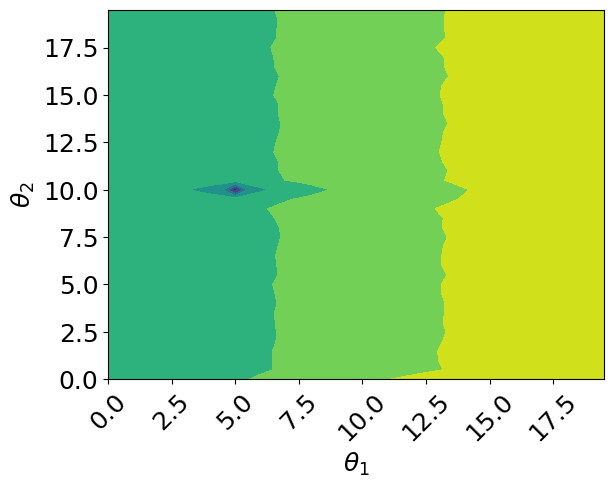

In [24]:
N_total = len(x_values)
Y_obs = np.reshape(Z_obs,(N_total,1))
t = [1,2]
print(J_(x_values,t,Y_obs))

t = np.arange(0,20,0.5)
Jt = [[J_(x_values,[ti,tj],Y_obs) for ti in t] for tj in t]
Jt = np.array(Jt)
T1,T2 = np.meshgrid(t,t)
plt.contourf(T1,T2,np.log(Jt))
plt.xlabel('$\\theta_1$',fontdict={'size':18})
plt.ylabel('$\\theta_2$',fontdict={'size':18})
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=18);

1453327670.446493


<ipython-input-25-e46316296fe5>:10: RuntimeWarning:

divide by zero encountered in log10



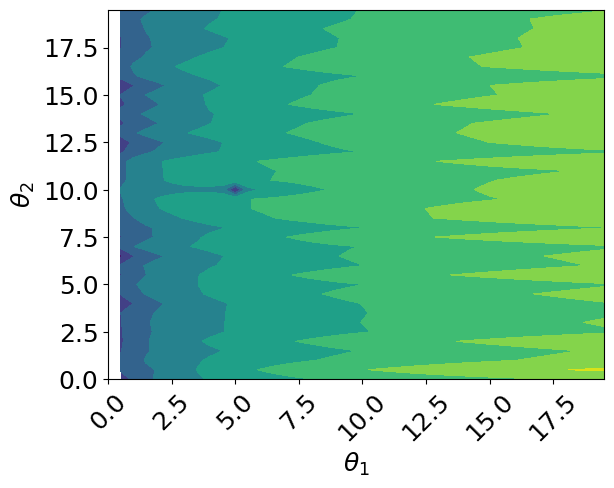

In [25]:
N_total = len(x_values)
Y_obs = np.reshape(Z_obs,(N_total,1))
t = [1,2]
print(J_(x_values,t,Y_obs))

t = np.arange(0,20,0.5)
Jt = [[np.linalg.norm(J_g(x_values,[ti,tj],Y_obs)) for ti in t] for tj in t]
Jt = np.array(Jt)
T1,T2 = np.meshgrid(t,t)
plt.contourf(T1,T2,np.log10(Jt))
plt.xlabel('$\\theta_1$',fontdict={'size':18})
plt.ylabel('$\\theta_2$',fontdict={'size':18})
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=18);

## Metodo de newton

In [26]:
t_k = np.array([10,10])
G = []
T = []

for i in range(0,100):
    T.append(t_k)
    J_g_k = J_g(x_values,t_k,Y_obs)
    G.append(np.linalg.norm(J_g_k))
    J_H_k = J_H(x_values,t_k,Y_obs)
    dt_k = np.linalg.solve(J_H_k,-J_g_k)
    t_k = t_k+dt_k

print(t_k)

[4.99998476 9.99999811]



## Normas de gradiente entre iteraciones

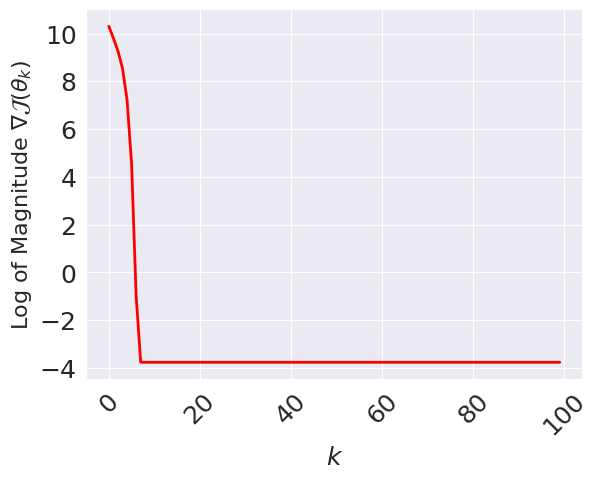

In [27]:
sns.set_style('darkgrid')
plt.plot(np.log10(G),color='r',lw=2)
plt.xlabel('$k$',fontdict={'size':18})
plt.ylabel('Log of Magnitude $\\nabla \\mathcal{J} ({\\theta}_k)$',fontdict={'size':16})
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=18);

In [ ]:
N_total = len(x_values)
Y_obs = np.reshape(Z_obs,(N_total,1))
t = [1,2]
print(J_(x_values,t,Y_obs))


T = np.array(T)

t = np.arange(0,20,0.5)
Jt = [[J_(x_values,[ti,tj],Y_obs) for ti in t] for tj in t]
Jt = np.array(Jt)
T1,T2 = np.meshgrid(t,t)
plt.contourf(T1,T2,np.log(Jt),cmap='Blues')
plt.plot(T[:,0],T[:,1],'-ko',lw=2)
plt.xlabel('$\\theta_1$',fontdict={'size':18})
plt.ylabel('$\\theta_2$',fontdict={'size':18})
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=18);

## Recovering Solution

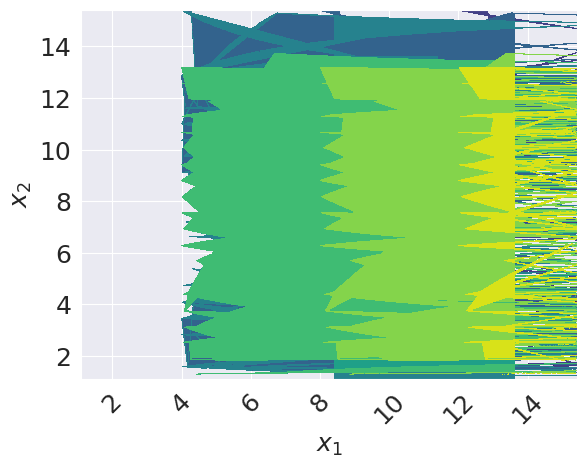

In [28]:
Z_newton = []
for xi in x_values:
    Z_newton.append(model_(xi,t_k))

Z_newton = np.array(Z_newton)
residuals = np.reshape(Z_newton,(n**2,1))-Y_obs

Z_newton = np.reshape(Z,(n,n))

X1,X2 = np.meshgrid(x,x)

plt.contourf(X1,X2,Z_newton,cmap='viridis')
plt.xlabel('$x_1$',fontdict={'size':18})
plt.ylabel('$x_2$',fontdict={'size':18})
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=18);

(112896, 1)


0.9990917227756961

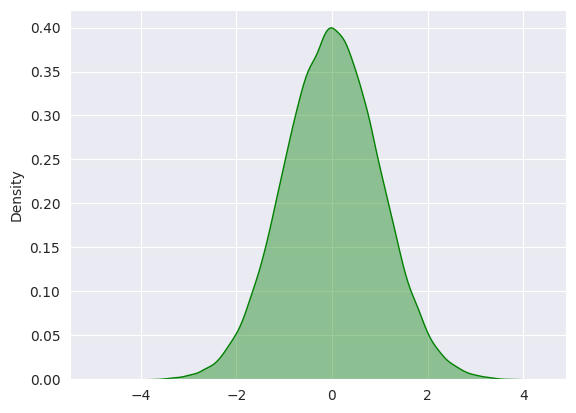

In [29]:
print(np.shape(residuals))
sns.kdeplot(residuals.transpose()[0],fill=True,alpha=0.4,color='green')
np.std(residuals.transpose()[0])


Observamos que los residuos siguen una distribución normal, entonces el modelo está capturando adecuadamente los componentes principales de la relación entre los datos observados y los parámetros del modelo.